# 네이버 검색어 트렌드 (Open API) 복수 단어
## 1. 작업 준비
### 1) 패키지 참조 및 그래프 한글 설정

In [31]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt
import sys
sys.path.append('../../')
from helper import set_datetime_index, exp_time_data

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [32]:
plt.rcParams['font.family'] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.unicode_minus'] = False

## 2. 네이버 검색어 트렌드 Open API 연동
### 1) 접속에 필요한 정보 설정
#### API url
- 'https://developers.naver.com/docs/serviceapi/datalab/search/search.md#%ED%86%B5%ED%95%A9-%EA%B2%80%EC%83%89%EC%96%B4-%ED%8A%B8%EB%A0%8C%EB%93%9C' 에 있음
    - '통합 검색어 트렌드 API 레퍼런스' -> '요청 URL' 

In [33]:
API_URL = 'https://openapi.naver.com/v1/datalab/search'

#### 발급받은 인증키
- 'https://developers.naver.com/apps/#/list'에 있음
    - 'application' -> '내 애플리케이션'
    - 내 거 개인
    - 하루 1000건 까지만 허용

In [34]:
client_id = 'E7zZdiJ9OvbDWhXGJLZB'
client_secret = 'vlizPe9VVf'

### 2) 접속 객체 생성

In [35]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

### 3) 전달할 검색어 구성

In [37]:
data = {
    "startDate": "2022-07-01",
    "endDate": "2023-07-31",
    "timeUnit": "date",     # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "Benz",    # 검색주제
            "keywords": ["e클래스", "s클래스", "c클래스", "벤츠 cls"] # 주제와 관련된 검색어
        },
        {
            "groupName": "BMW",    # 검색주제
            "keywords": ["5시리즈", "x5", "x7", "x3"] # 주제와 관련된 검색어
        },
        {
            "groupName": "AUDI",    # 검색주제
            "keywords": ["a6", "e트론", "a7", "q5"] # 주제와 관련된 검색어
        }
    ]
}

### 4) 데이터 요청하기

In [39]:
r = session.post(API_URL, data = json.dumps(data))

if r.status_code != 200:
    msg = '[%d Error] $s 에러가 발생함' % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = 'utf-8'
mydict = json.loads(r.text)
mydict

{'startDate': '2022-07-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': 'Benz',
   'keywords': ['e클래스', 's클래스', 'c클래스', '벤츠 cls'],
   'data': [{'period': '2022-07-01', 'ratio': 26.82426},
    {'period': '2022-07-02', 'ratio': 28.60838},
    {'period': '2022-07-03', 'ratio': 27.98394},
    {'period': '2022-07-04', 'ratio': 27.69848},
    {'period': '2022-07-05', 'ratio': 28.49241},
    {'period': '2022-07-06', 'ratio': 28.29616},
    {'period': '2022-07-07', 'ratio': 29.34879},
    {'period': '2022-07-08', 'ratio': 28.76003},
    {'period': '2022-07-09', 'ratio': 30.21409},
    {'period': '2022-07-10', 'ratio': 29.66993},
    {'period': '2022-07-11', 'ratio': 30.66904},
    {'period': '2022-07-12', 'ratio': 29.49152},
    {'period': '2022-07-13', 'ratio': 27.69848},
    {'period': '2022-07-14', 'ratio': 29.24174},
    {'period': '2022-07-15', 'ratio': 28.84032},
    {'period': '2022-07-16', 'ratio': 29.87511},
    {'period': '2022-07-17', 'ratio': 30.6958},
   

### 5) 응답 결과 구조

In [44]:
print('검색 결과 수: ', len(mydict['results']))

검색 결과 수:  3


In [73]:
my_dict = {}
for a in range(len(mydict['results'])):
    title = mydict['results'][a]['title']
    # print(title)

    data = mydict['results'][a]['data']
    df = DataFrame(data)
    df.rename(columns={'ratio':title}, inplace=True)
    # print(df.head())
    my_dict[a] = df

{0:          period      Benz
0    2022-07-01  26.82426
1    2022-07-02  28.60838
2    2022-07-03  27.98394
3    2022-07-04  27.69848
4    2022-07-05  28.49241
..          ...       ...
391  2023-07-27  33.31846
392  2023-07-28  36.15521
393  2023-07-29  36.05709
394  2023-07-30  36.82426
395  2023-07-31  36.40499

[396 rows x 2 columns], 1:          period       BMW
0    2022-07-01  38.63514
1    2022-07-02  40.09812
2    2022-07-03  42.46208
3    2022-07-04  41.94469
4    2022-07-05  42.69402
..          ...       ...
391  2023-07-27  61.78412
392  2023-07-28  66.67261
393  2023-07-29  67.38626
394  2023-07-30  67.67172
395  2023-07-31  69.73238

[396 rows x 2 columns], 2:          period      AUDI
0    2022-07-01  18.32292
1    2022-07-02  18.50133
2    2022-07-03  19.56289
3    2022-07-04  19.23282
4    2022-07-05  18.73327
..          ...       ...
391  2023-07-27  17.88581
392  2023-07-28  19.30419
393  2023-07-29  17.71632
394  2023-07-30  16.85994
395  2023-07-31  18.92060

[39

### 6) 생성된 데이터프레임 병합

In [76]:
tmp = merge(my_dict[0], my_dict[1], how='outer')
df = merge(tmp, my_dict[2], how='outer')
df

,period,Benz,BMW,AUDI
0,2022-07-01,26.82426,38.63514,18.32292
1,2022-07-02,28.60838,40.09812,18.50133
2,2022-07-03,27.98394,42.46208,19.56289
3,2022-07-04,27.69848,41.94469,19.23282
4,2022-07-05,28.49241,42.69402,18.73327
...,...,...,...,...
391,2023-07-27,33.31846,61.78412,17.88581
392,2023-07-28,36.15521,66.67261,19.30419
393,2023-07-29,36.05709,67.38626,17.71632
394,2023-07-30,36.82426,67.67172,16.85994


## 3. 연동 결과에 대한 시계열 분석
### 1) 데이터 타입 확인

In [77]:
df.dtypes

period     object
Benz      float64
BMW       float64
AUDI      float64
dtype: object

### 2) 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [78]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2

,Benz,BMW,AUDI
2022-07-01,26.82426,38.63514,18.32292
2022-07-02,28.60838,40.09812,18.50133
2022-07-03,27.98394,42.46208,19.56289
2022-07-04,27.69848,41.94469,19.23282
2022-07-05,28.49241,42.69402,18.73327
...,...,...,...
2023-07-27,33.31846,61.78412,17.88581
2023-07-28,36.15521,66.67261,19.30419
2023-07-29,36.05709,67.38626,17.71632
2023-07-30,36.82426,67.67172,16.85994


In [80]:
df3 = df2.reset_index()
df3

,index,Benz,BMW,AUDI
0,2022-07-01,26.82426,38.63514,18.32292
1,2022-07-02,28.60838,40.09812,18.50133
2,2022-07-03,27.98394,42.46208,19.56289
3,2022-07-04,27.69848,41.94469,19.23282
4,2022-07-05,28.49241,42.69402,18.73327
...,...,...,...,...
391,2023-07-27,33.31846,61.78412,17.88581
392,2023-07-28,36.15521,66.67261,19.30419
393,2023-07-29,36.05709,67.38626,17.71632
394,2023-07-30,36.82426,67.67172,16.85994


In [82]:
df4 = melt(df3, 
           id_vars=['index'], 
           value_vars=['Benz', 'BMW', 'AUDI'],
           var_name='키워드', 
           value_name='검색량')
df4.set_index('index', inplace=True)
df4

,키워드,검색량
index,,
2022-07-01,Benz,26.82426
2022-07-02,Benz,28.60838
2022-07-03,Benz,27.98394
2022-07-04,Benz,27.69848
2022-07-05,Benz,28.49241
...,...,...
2023-07-27,AUDI,17.88581
2023-07-28,AUDI,19.30419
2023-07-29,AUDI,17.71632


### 3) 시각화

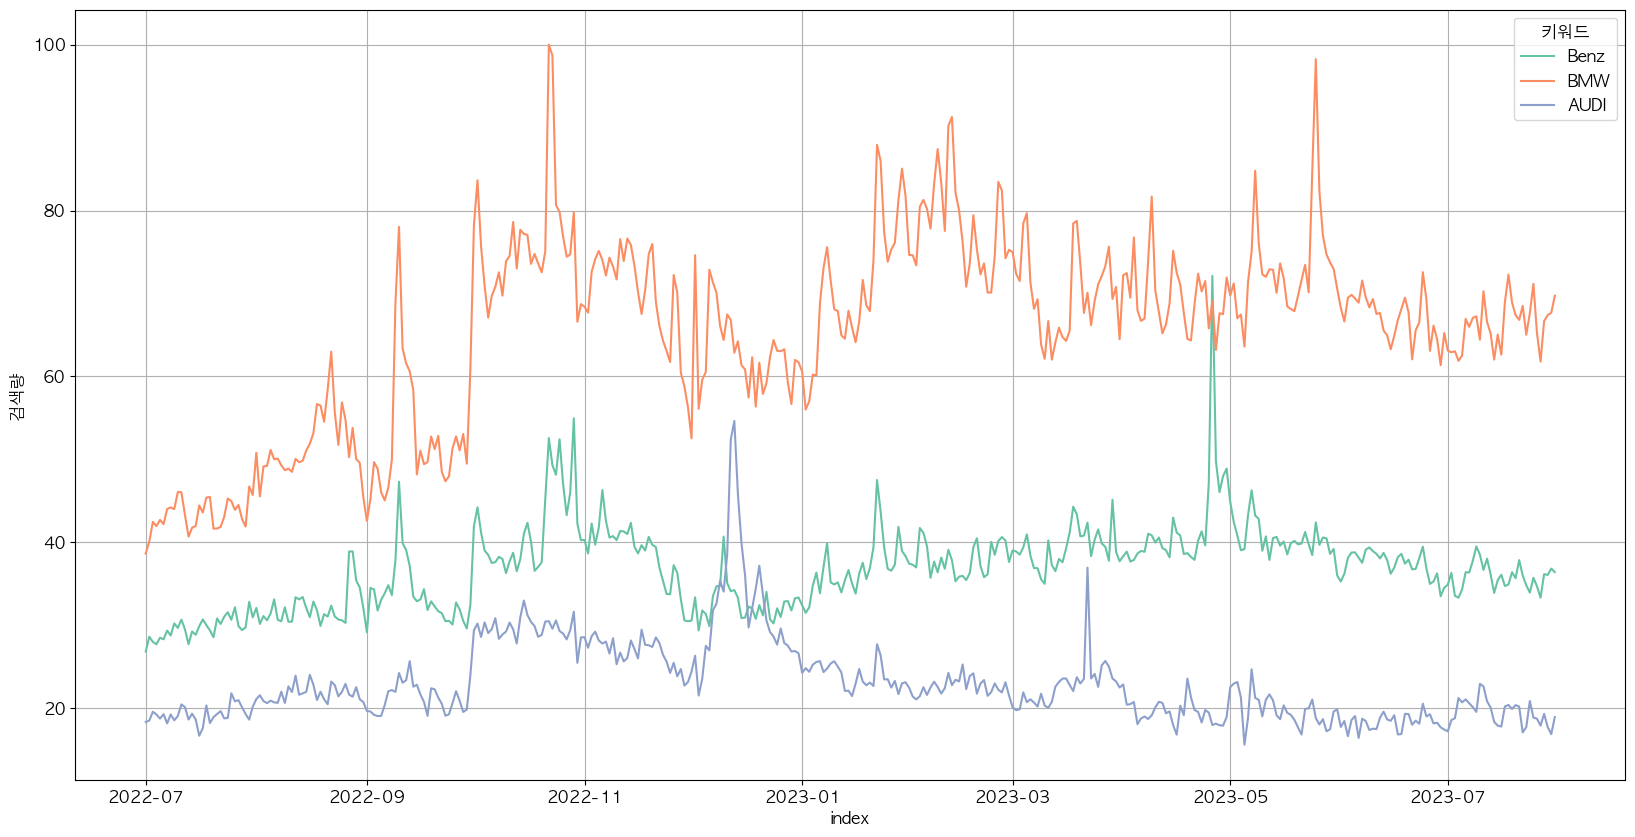

In [83]:
plt.figure(figsize=(20, 10))
sb.lineplot(data=df4, 
            y='검색량', 
            x=df4.index, 
            hue='키워드', 
            palette='Set2')
plt.grid()
plt.show()
plt.close()

### 4) helper에 구현된 기능 활용하여 데이터 검정

Benz
결측치 수: 0


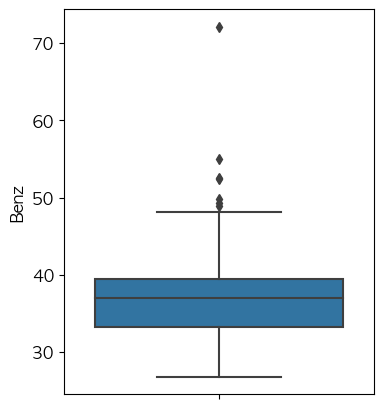

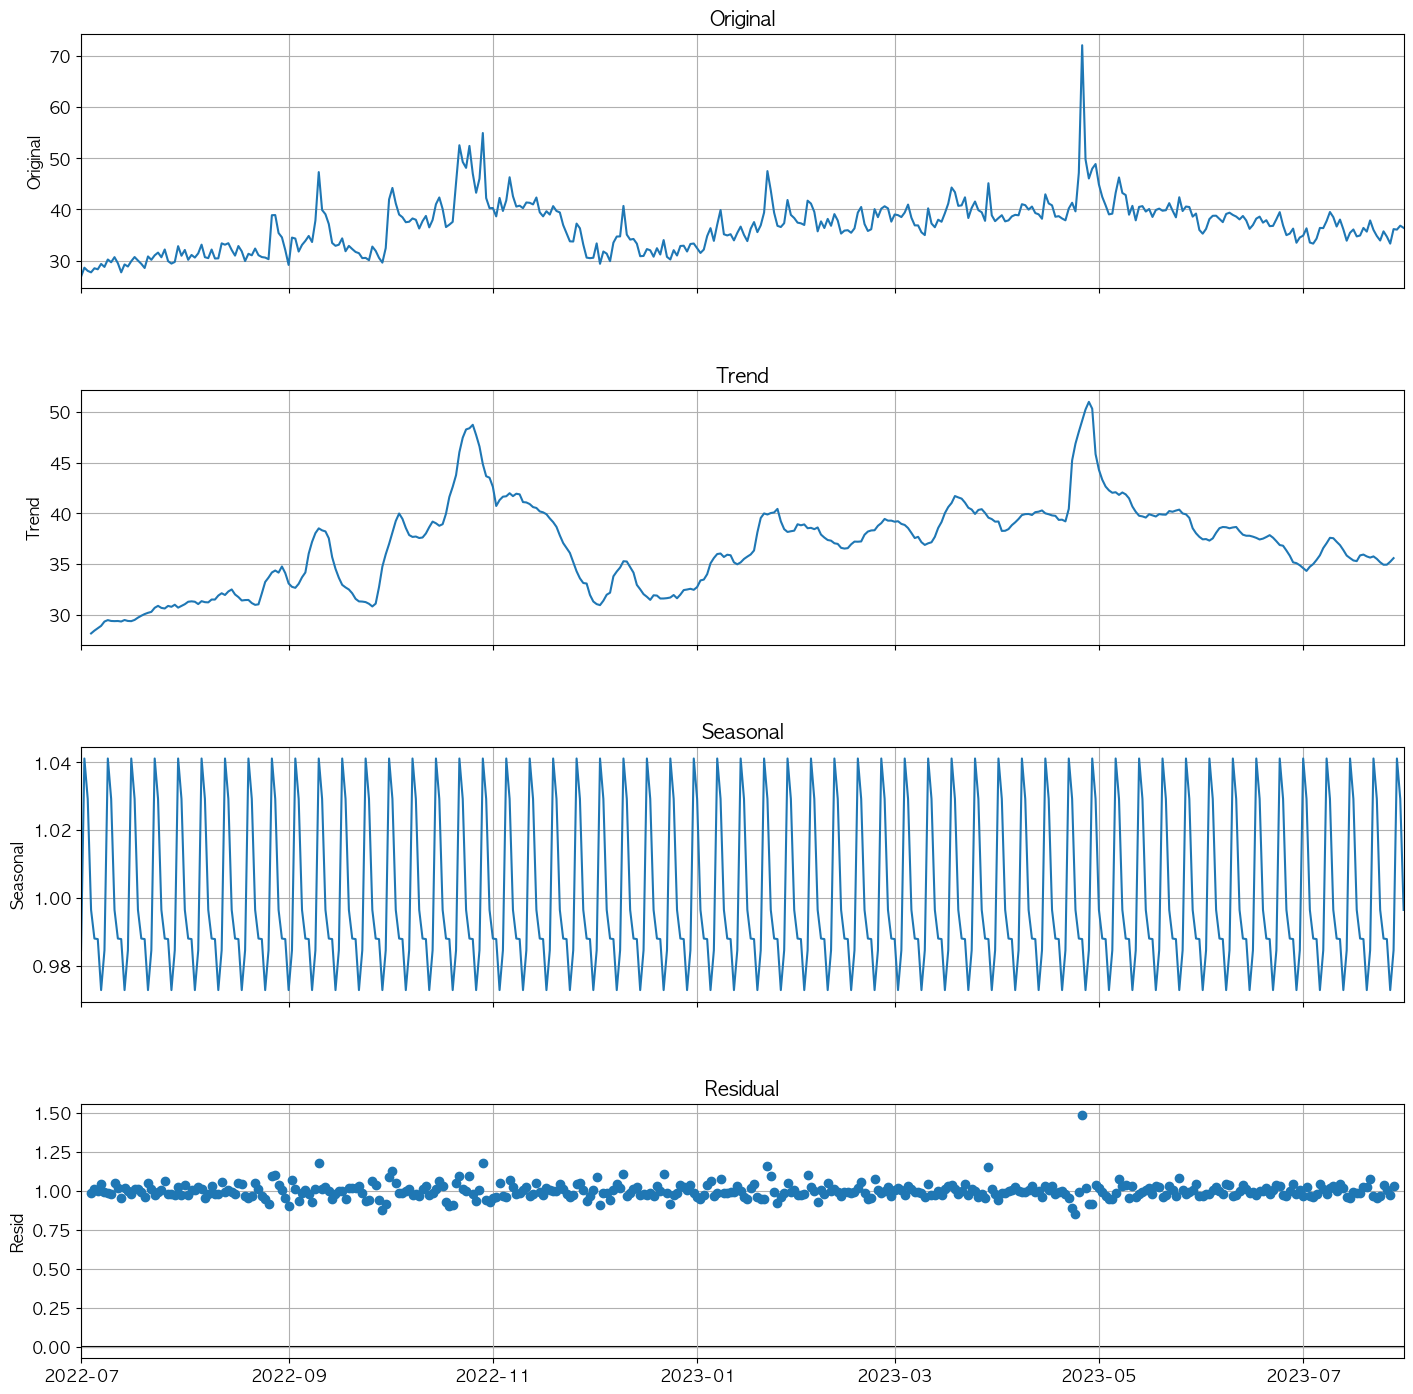

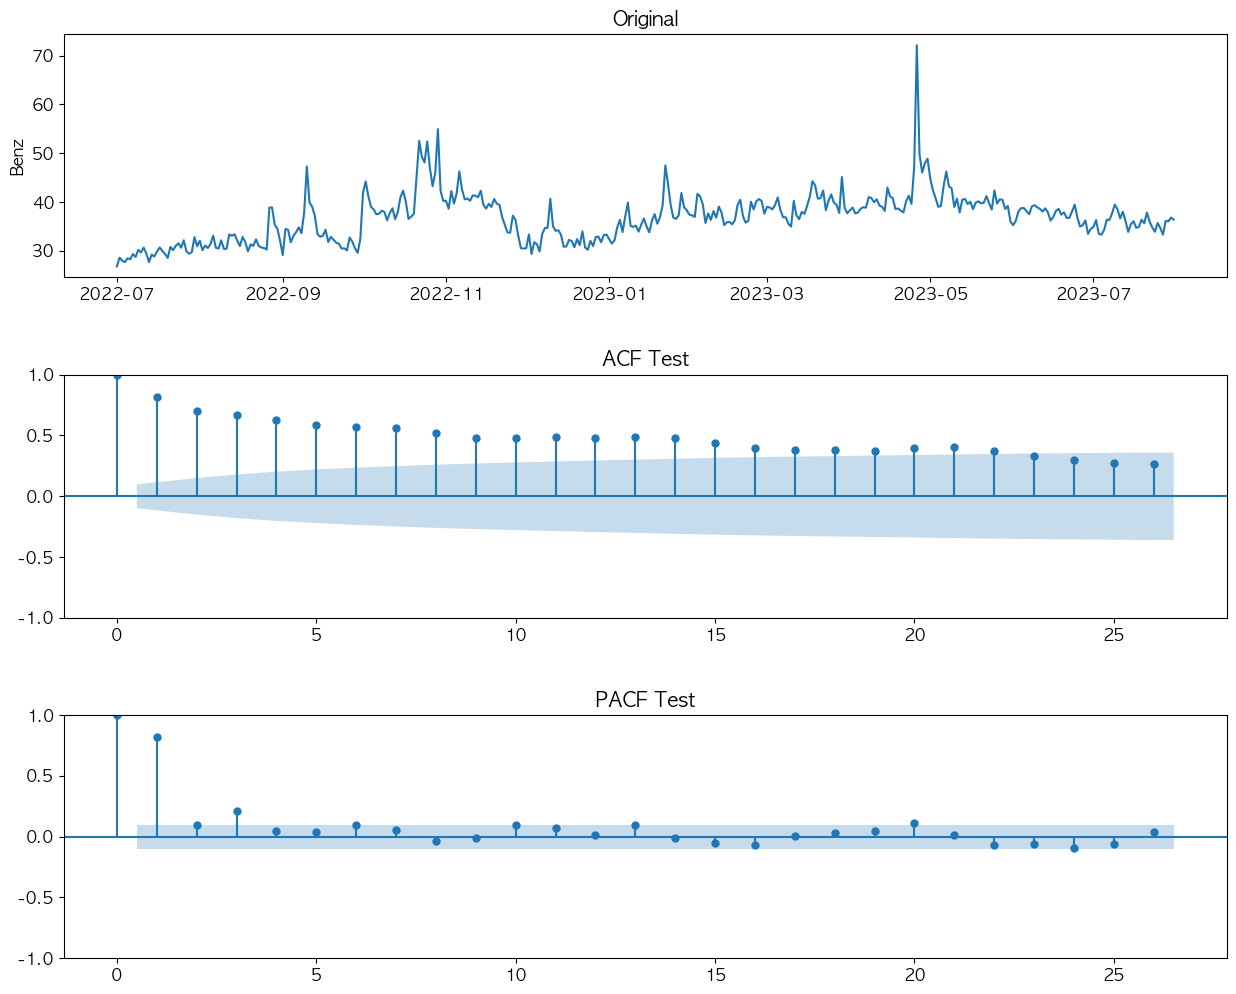

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.34129 |
| 유의수준(p-value)                  | 0.000376494 |
| 최적차수(num of lags)              |           2 |
| 관측치 개수(num of observations)   |         393 |
| 기각값(Critical Values) 1%         |     -3.4471 |
| 기각값(Critical Values) 5%         |    -2.86892 |
| 기각값(Critical Values) 10%        |     -2.5707 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+
BMW
결측치 수: 0


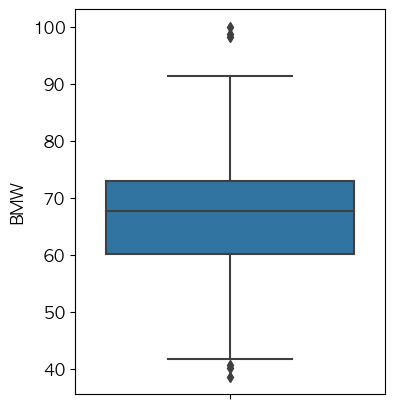

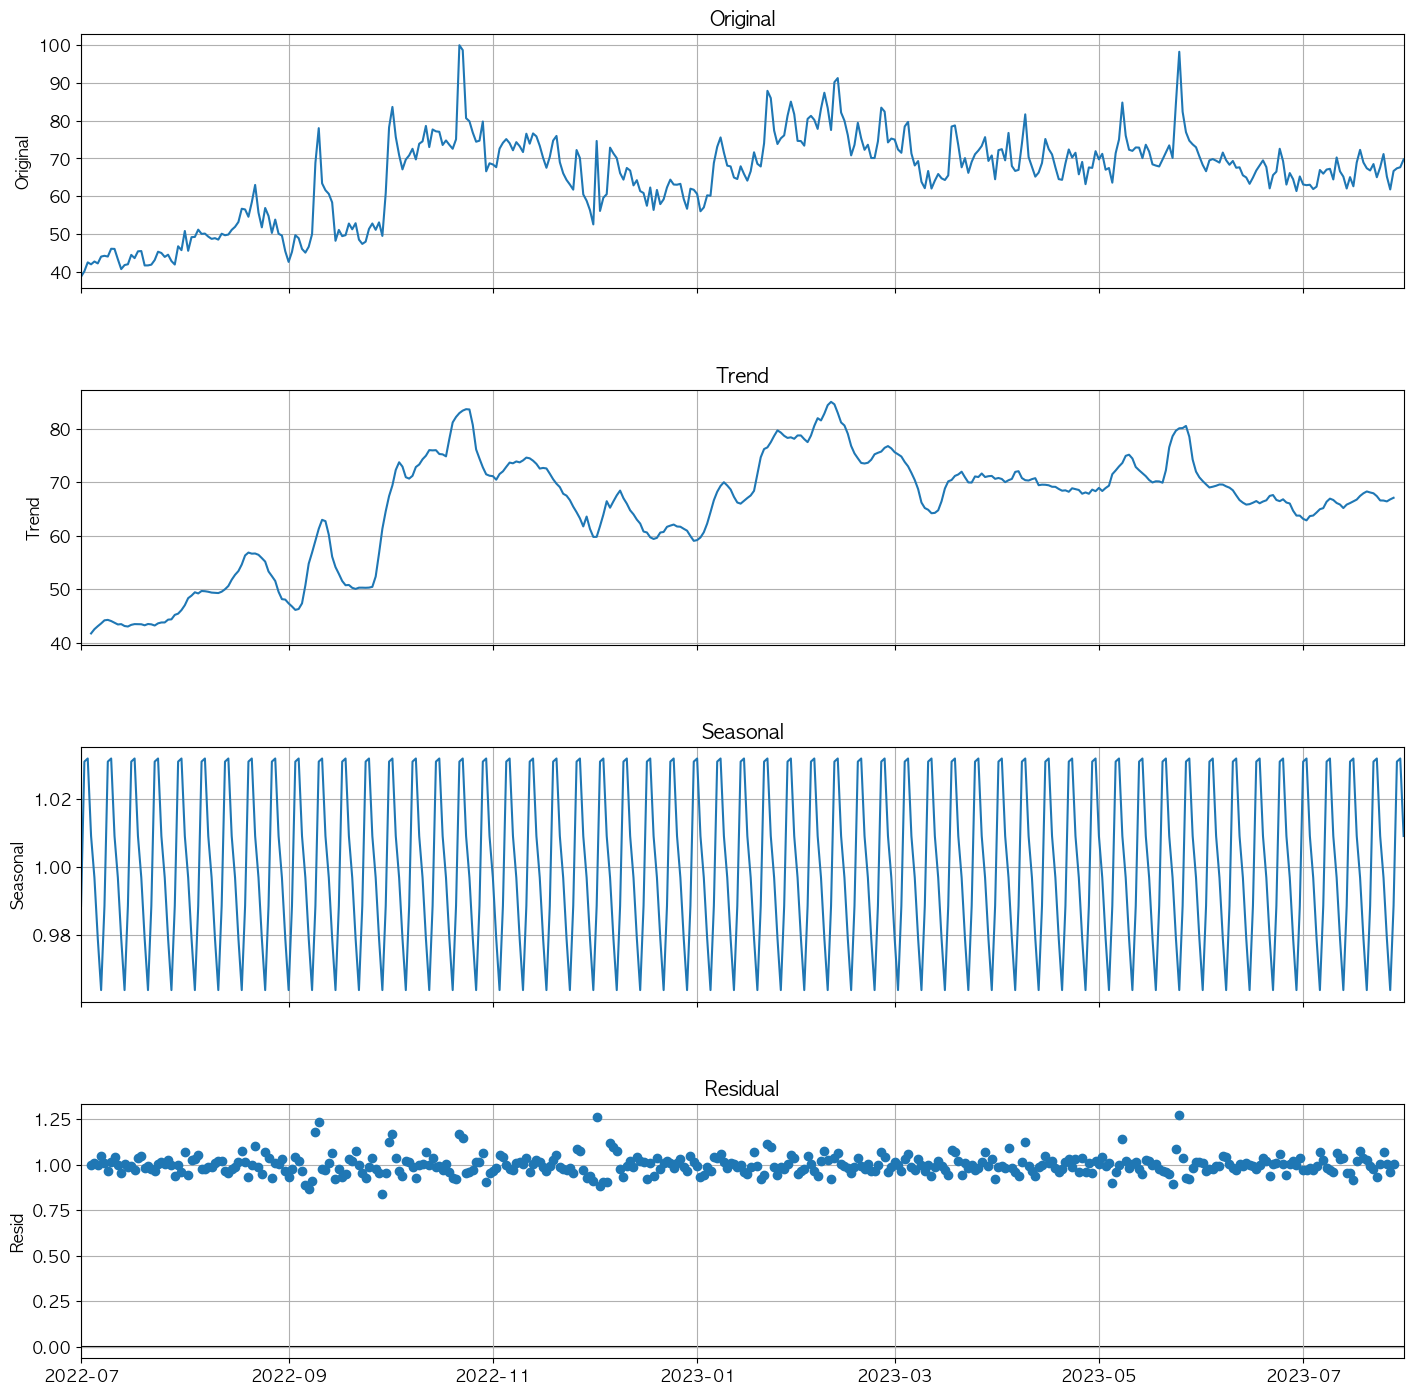

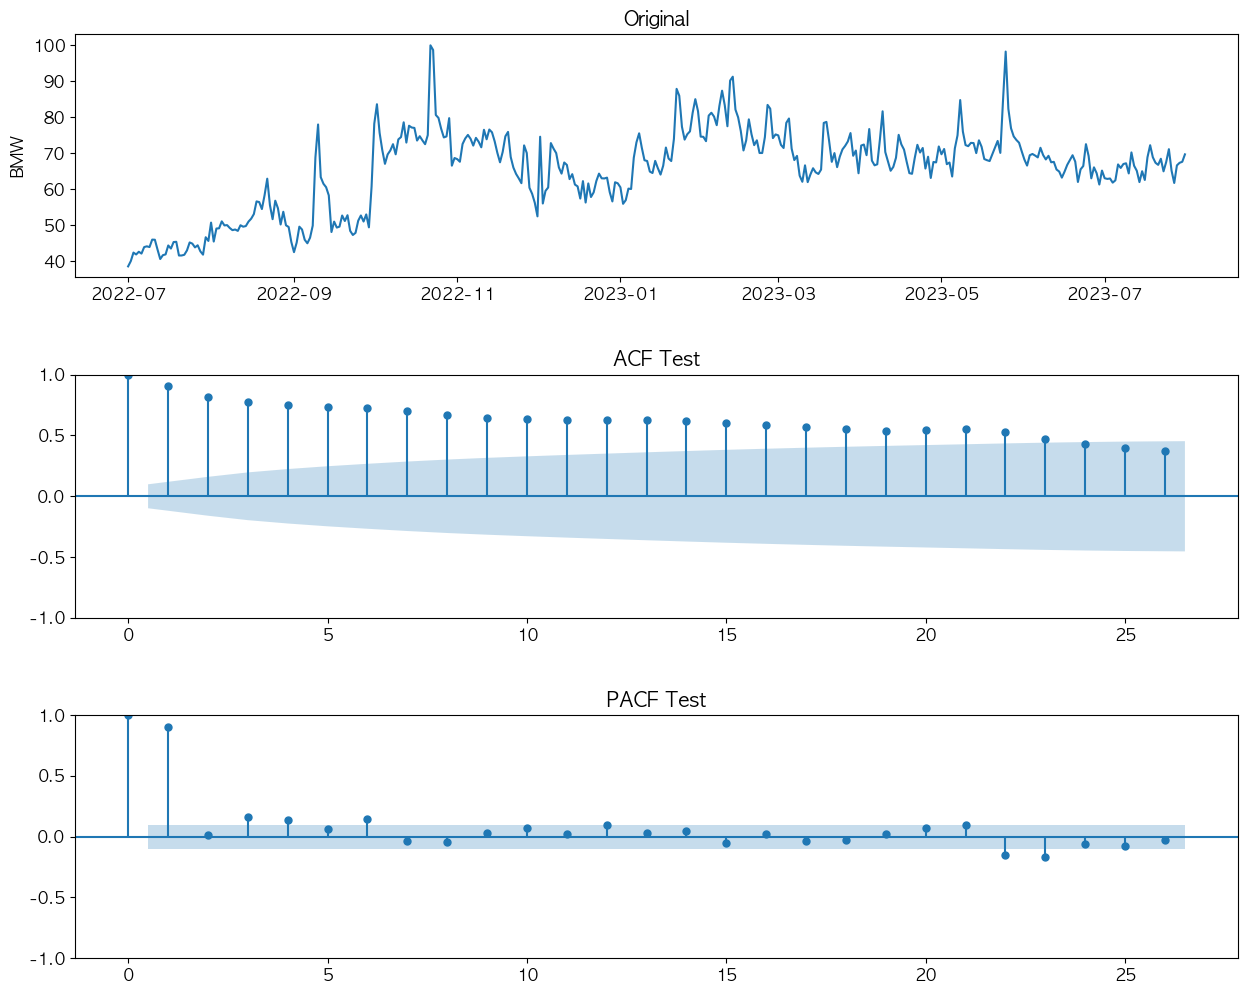

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -2.81564 |
| 유의수준(p-value)                  | 0.0560744 |
| 최적차수(num of lags)              |         5 |
| 관측치 개수(num of observations)   |       390 |
| 기각값(Critical Values) 1%         |  -3.44723 |
| 기각값(Critical Values) 5%         |  -2.86898 |
| 기각값(Critical Values) 10%        |  -2.57073 |
| 데이터 정상성 여부(0=Flase,1=True) |         0 |
+------------------------------------+-----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -13.2981 |
| 유의수준(p-value)                  | 7.13718e-25 |
| 최적차수(num of lags)              |           4 |
| 관측치 개수(num of observations)   |         390 |
| 기각값

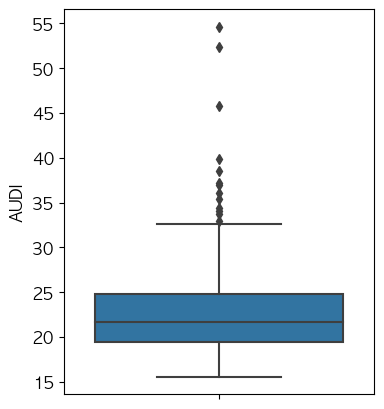

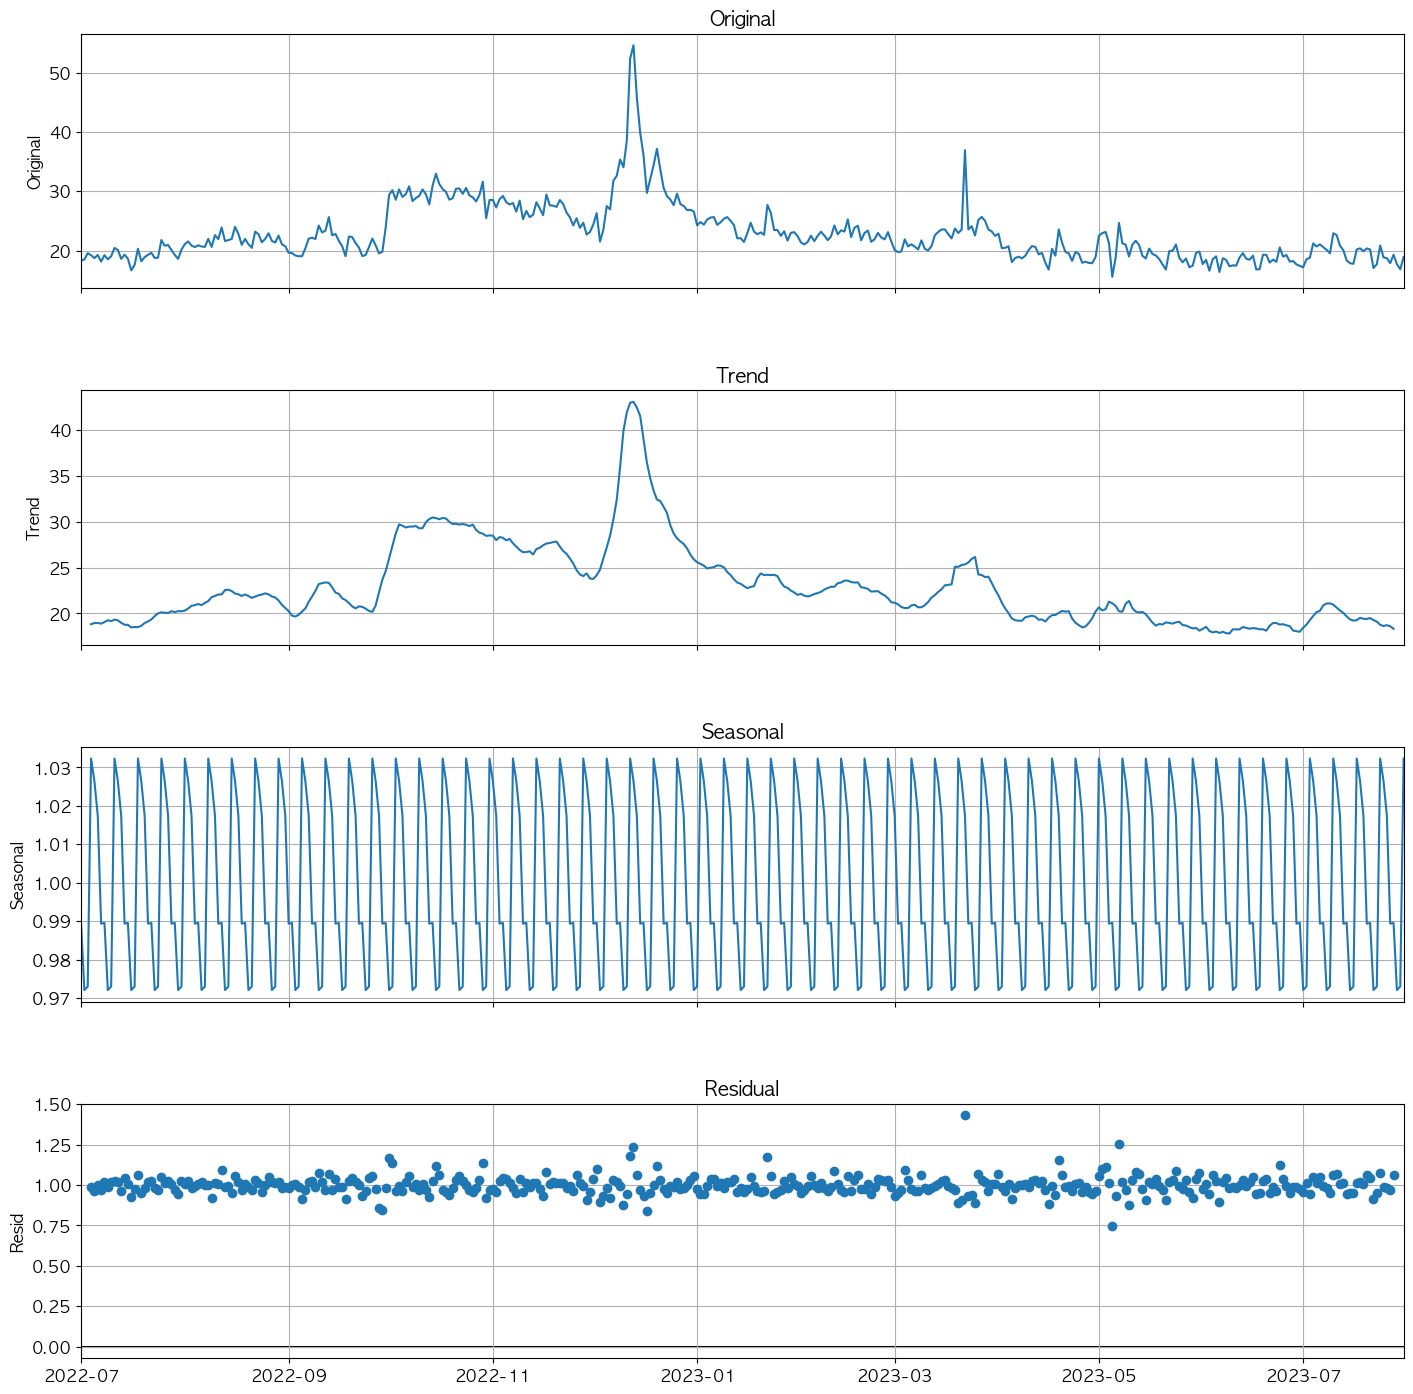

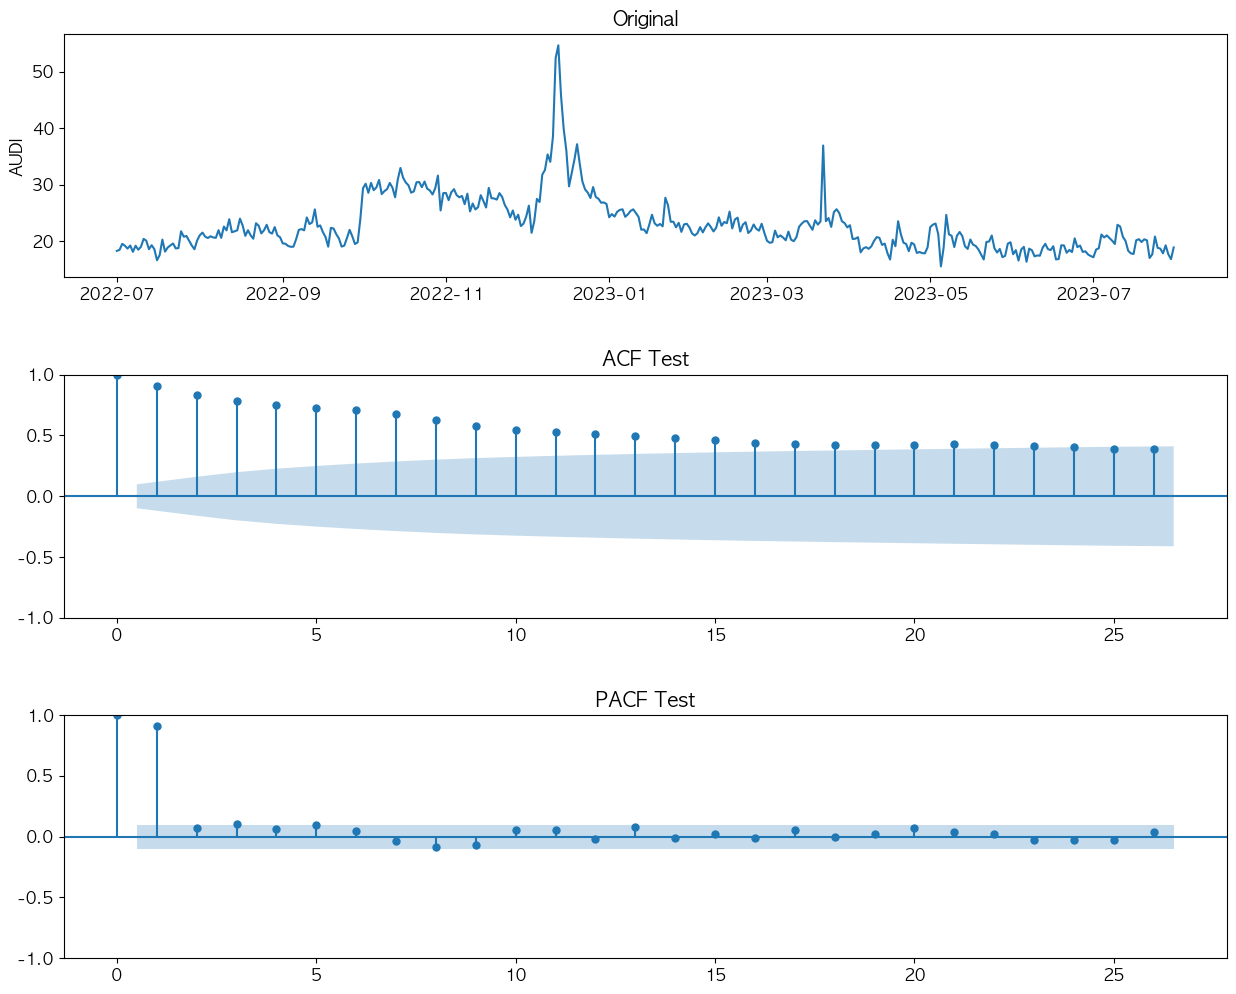

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -2.79739 |
| 유의수준(p-value)                  | 0.0586475 |
| 최적차수(num of lags)              |         4 |
| 관측치 개수(num of observations)   |       391 |
| 기각값(Critical Values) 1%         |  -3.44719 |
| 기각값(Critical Values) 5%         |  -2.86896 |
| 기각값(Critical Values) 10%        |  -2.57072 |
| 데이터 정상성 여부(0=Flase,1=True) |         0 |
+------------------------------------+-----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -12.9999 |
| 유의수준(p-value)                  | 2.7013e-24 |
| 최적차수(num of lags)              |          3 |
| 관측치 개수(num of observations)   |        391 |
| 기각값(Critic

In [84]:
for c in df2.columns:
    print("=========================================")
    print(c)
    print("=========================================")

    exp_time_data(df2, c, "m", max_diff=10)

### 5) ARIMA 분석 수행
#### 1. 분석 모델 구성

In [85]:
pdq = (
    ((1,0,0),(1,0,0,7)),    # 0번째
    ((1,1,0),(1,1,0,7)),    # 1번째
    ((1,1,0),(1,1,0,7))     # 2번째
)

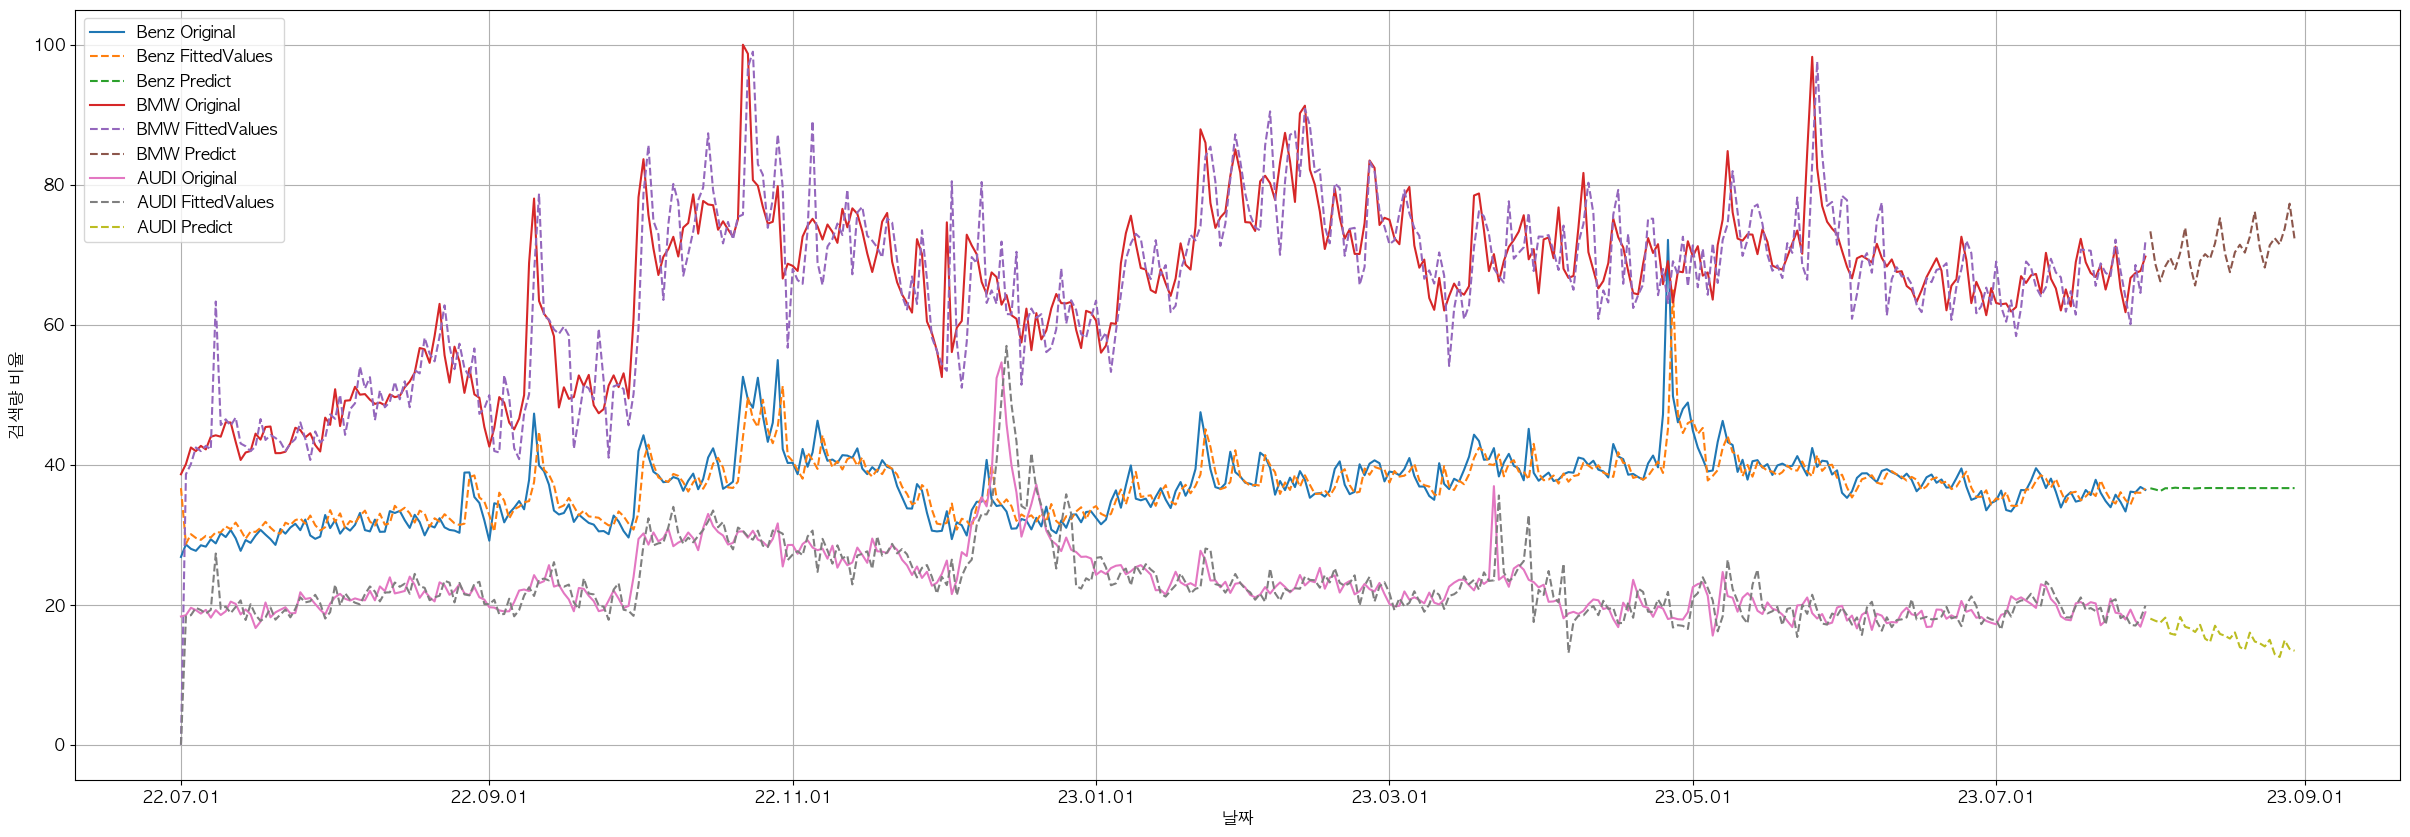

In [86]:
plt.figure(figsize=(30,10))

for i, c in enumerate(df2.columns):
    # 모델 구성
    model = ARIMA(df2[c], order=pdq[i][0], seasonal_order=pdq[i][1])
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 예측값
    fc = fit.forecast(30)
    
    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues' % c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()